## ECSE415 - Into to Computer Vision
## Assignment 3
### Alexander Harris - 260688155

## 2 - Stereo Vision
### 2.2 - Epipolar Geometry

In [1]:
import cv2
import numpy as np
import sys
import re
import math
import time
from struct import *
from matplotlib import pyplot as plt

def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
    return img.astype(np.uint8)

In [2]:
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

In [3]:
def plotFigures(images):
    """
    Plots images from list in grid.
    
    images: list of images
    title: title for each subplot
    params: specific arguments to add to title
    """
    grid_len = math.ceil(math.sqrt(len(images)))
    
    plt.figure(figsize=(30, 30))
    for i, image in enumerate(images):
        plt.subplot(grid_len, grid_len, i+1), plt.imshow(image['image'], 'gray')
        plt.title('{} - {}'.format(image['title'], image['params'])), plt.axis('off')
    plt.show()

In [4]:
# Import left and right images
imgL = cv2.imread('./dataset/im0.png', 0)
imgR = cv2.imread('./dataset/im1.png', 0)

In [5]:
sift = cv2.xfeatures2d.SIFT_create()
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# Compute SIFT keypoints and descriptors
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# Find matches
matches = bfMatcher.knnMatch(desL, desR, k=2)

good = []
ptsL = []
ptsR = []
bad = []
ptsL_bad = []
ptsR_bad = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)
    else:
        bad.append(m)
        ptsR_bad.append(kpR[m.trainIdx].pt)
        ptsL_bad.append(kpL[m.queryIdx].pt)

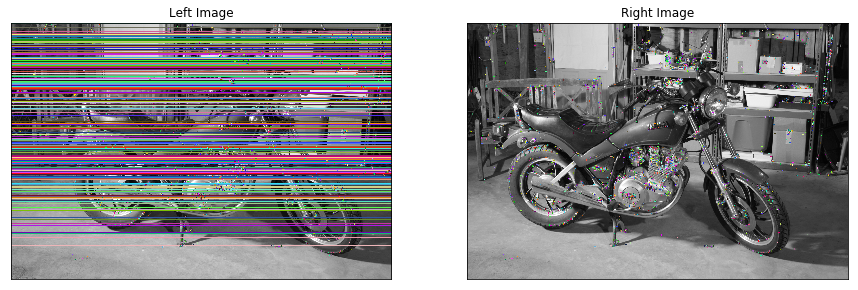

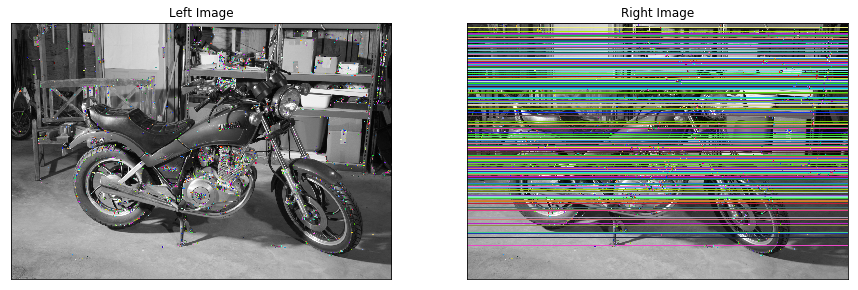

In [6]:
# Compute fundamental matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
ptsL_bad = np.int32(ptsL_bad)
ptsR_bad = np.int32(ptsR_bad)

F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Compute epipolar lines
ptsL = ptsL[mask.ravel() == 1]
ptsR = ptsR[mask.ravel() == 1]

linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)

imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)

imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# Display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1)
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1)
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2)
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2)
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

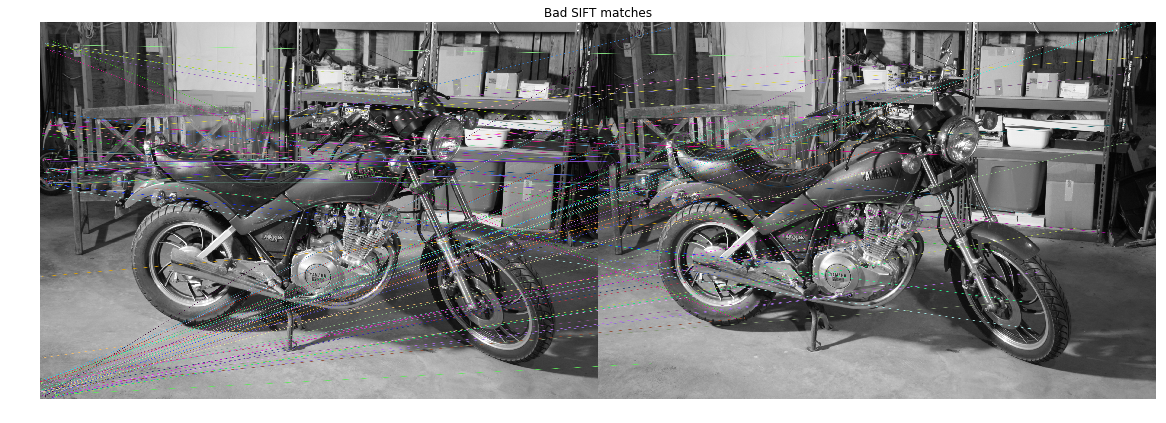

In [7]:
# Show bad matches
bad_img = cv2.drawMatches(imgL, kpL, imgR, kpR, bad[:100], imgL, flags=2)
plt.figure(figsize=(20,20))
plt.imshow(bad_img), plt.axis('off')
plt.title('Bad SIFT matches')
plt.show()

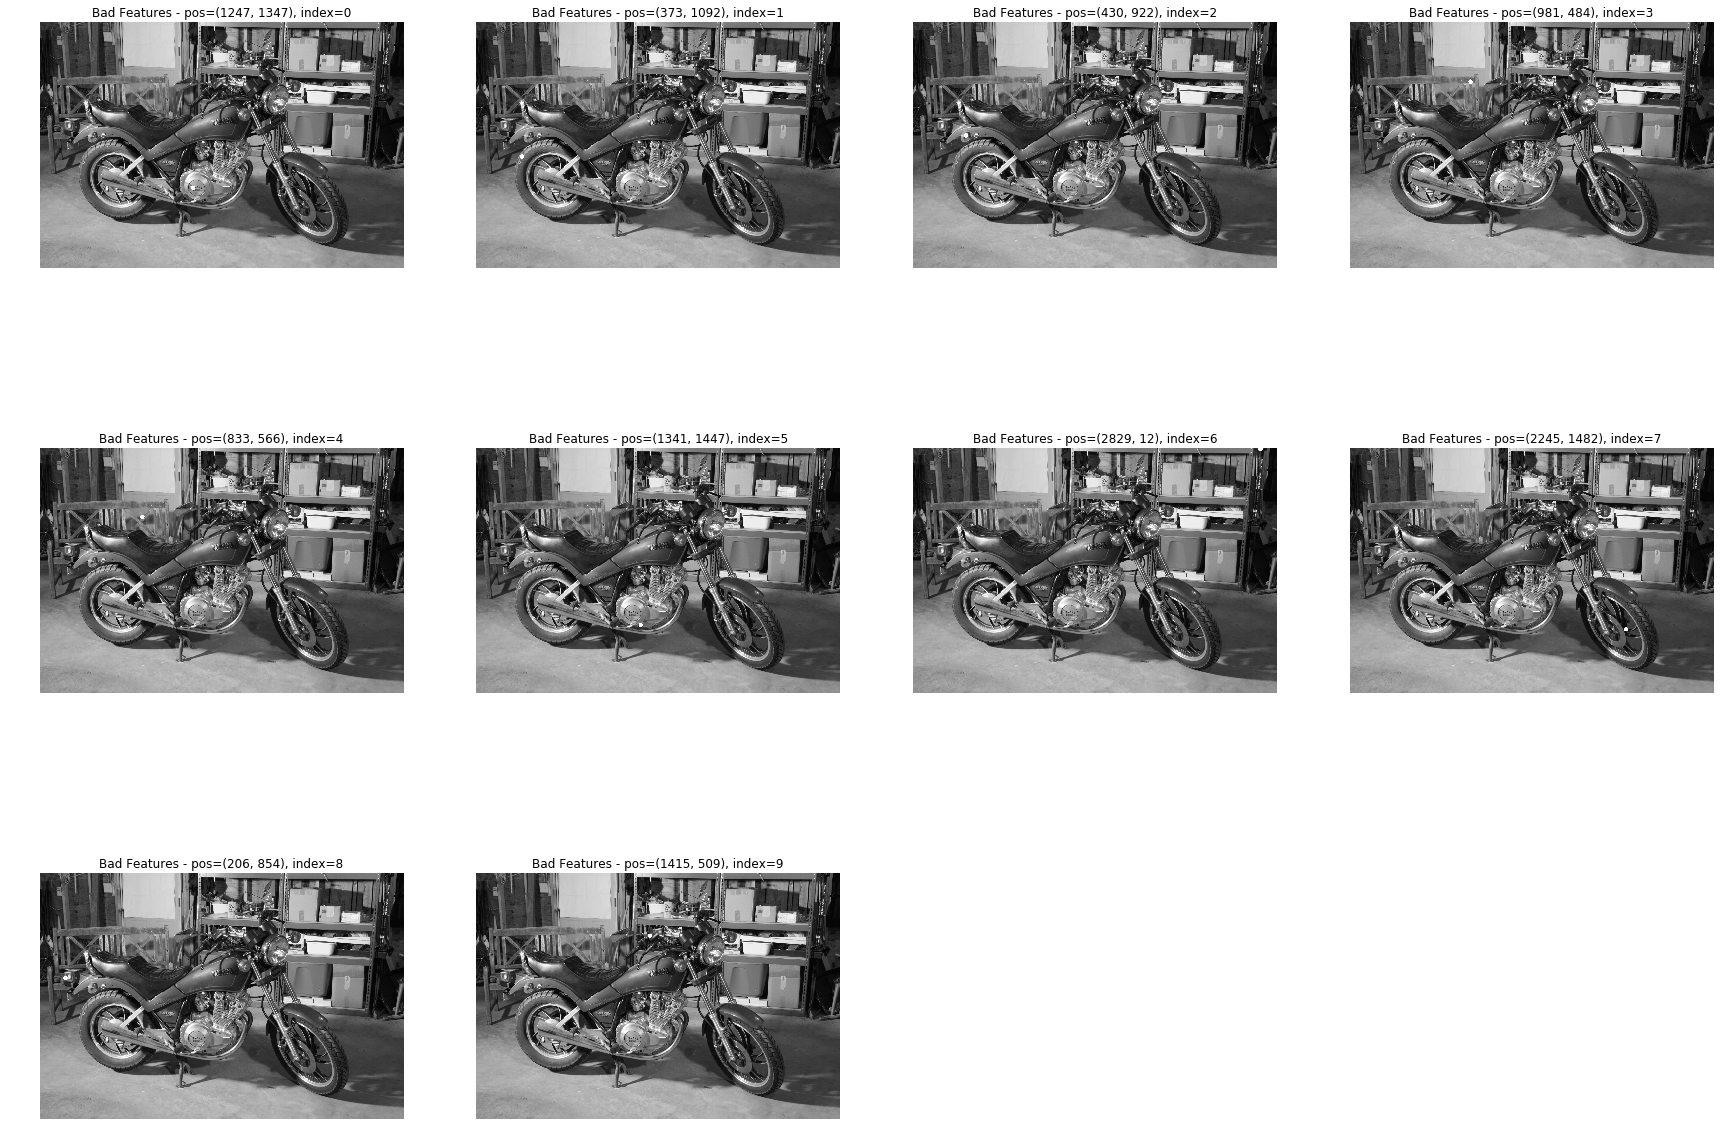

In [8]:
# Display some of the bad matches
images = []
for i, point in enumerate(ptsR_bad[:10]):
    kp = tuple([point[0], point[1]])
    bad_matches = imgR.copy()
    bad_matches = cv2.circle(bad_matches, kp, 18, (255,255,255), -1)
    images.append({'image': bad_matches, 'title': 'Bad Features', 'params': 'pos={}, index={}'.format(kp, i)})
plotFigures(images)

In [9]:
def get_patch(img, center, size=5):
    x = center[0]
    y = center[1]
    
    min_delta = size // 2
    max_delta = size // 2 + 1
    
    x_0, x_1 = x - min_delta, x + max_delta
    y_0, y_1 = y - min_delta, y + max_delta
    
    return img[y_0:y_1, x_0:x_1]

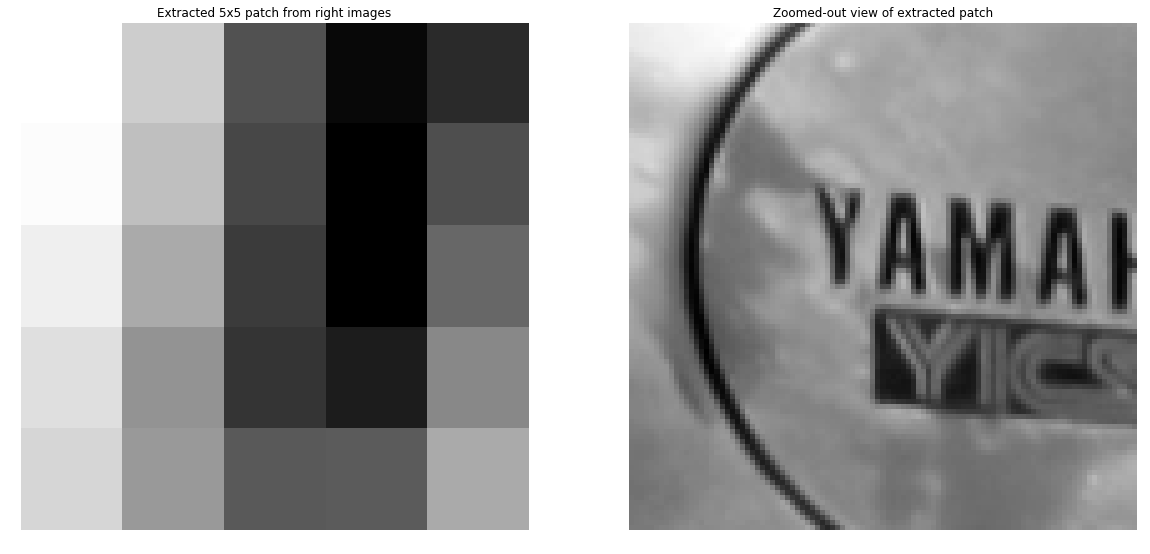

In [10]:
# We will choose the keypoint at index 0, which corresponds to the Yamaha logo
bad_point = ptsR_bad[0]
patch = get_patch(imgR, bad_point)
zoom = 100
bigger_patch = get_patch(imgR, bad_point, size=zoom)

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(patch, 'gray')
plt.title('Extracted 5x5 patch from right images'), plt.axis('off')
plt.subplot(122), plt.imshow(bigger_patch, 'gray')
plt.title('Zoomed-out view of extracted patch'), plt.axis('off')
plt.show()

In [11]:
def get_patches(img, point, size=5):
    h, w = img.shape
    y = point[1]
    min_delta = size // 2
    max_delta = size // 2 + 1
        
    patches = []
    for i in range(min_delta, w - max_delta):
        patch = img[y-min_delta:y+max_delta, i-min_delta:i+max_delta]
        patches.append(patch)
    return patches

In [12]:
# Get patches along corresponding line in left image
left_patches = get_patches(imgL, bad_point)

In [25]:
def calculate_ssd(patches, test_patch):
    ssd = []
    for patch in patches:
        sq_diff = (test_patch - patch) ** 2
        mean = np.mean(sq_diff)
        ssd.append(mean)
    min_ssd = min(ssd)
    return ssd, min_ssd, ssd.index(min_ssd)

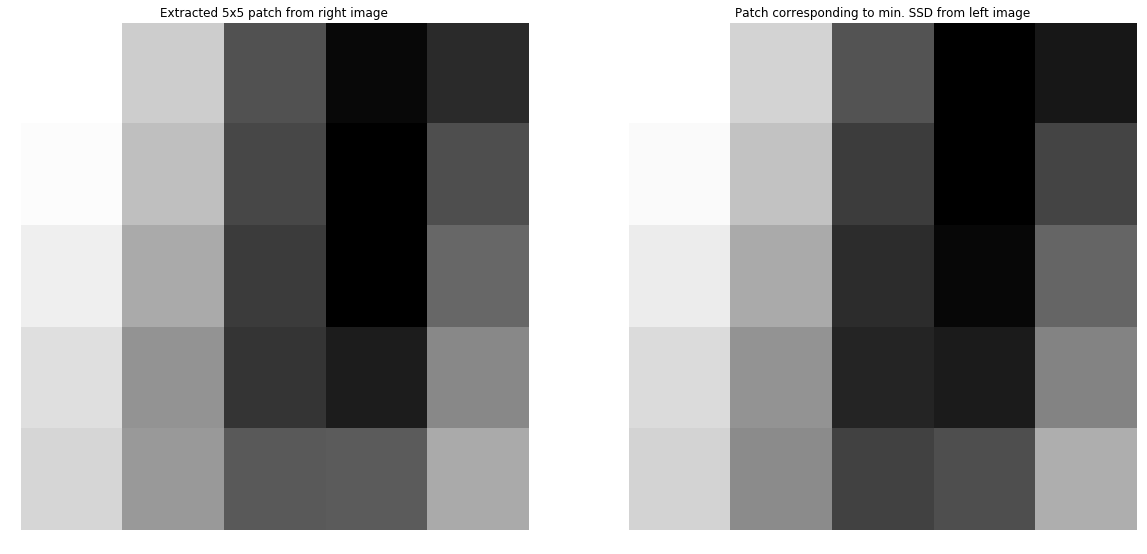

In [26]:
# Compute SSD and find patch corresponding to minimum
ssd, min_ssd, min_idx = calculate_ssd(left_patches, patch)
min_patch = left_patches[min_idx]

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(patch, 'gray')
plt.title('Extracted 5x5 patch from right image'), plt.axis('off')
plt.subplot(122), plt.imshow(min_patch, 'gray')
plt.title('Patch corresponding to min. SSD from left image'), plt.axis('off')
plt.show()

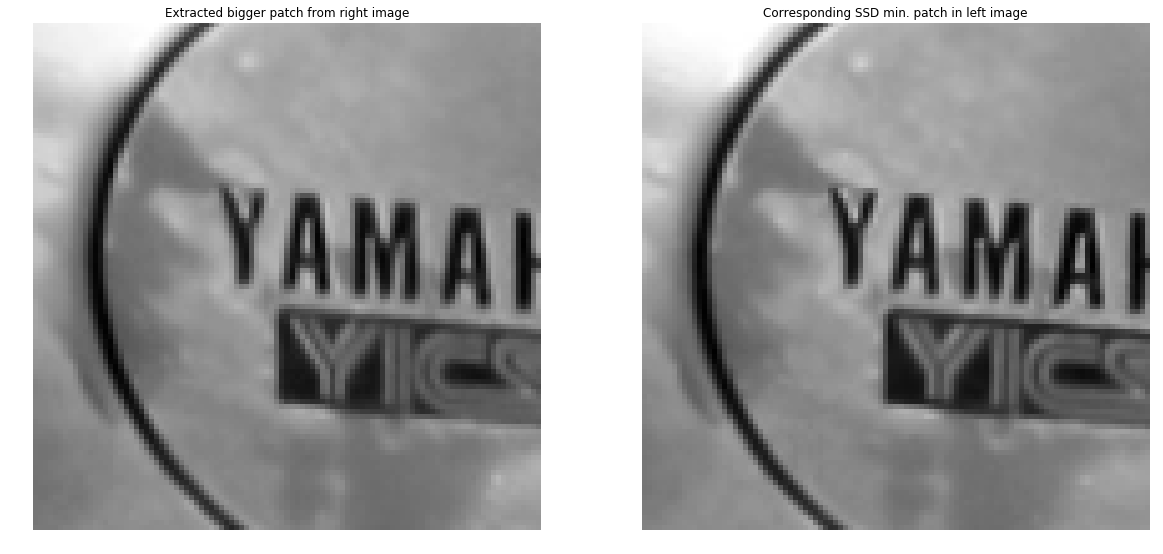

In [27]:
# Lets zoom out to find out how close we are
patches_bigger = get_patches(imgL, bad_point, size=zoom)
ssd_big, min_ssd_big, min_idx_big = calculate_ssd(patches_bigger, bigger_patch)
min_patch_bigger = patches_bigger[min_idx_big]

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(bigger_patch, 'gray')
plt.title('Extracted bigger patch from right image'), plt.axis('off')
plt.subplot(122), plt.imshow(min_patch_bigger, 'gray')
plt.title('Corresponding SSD min. patch in left image'), plt.axis('off')
plt.show()

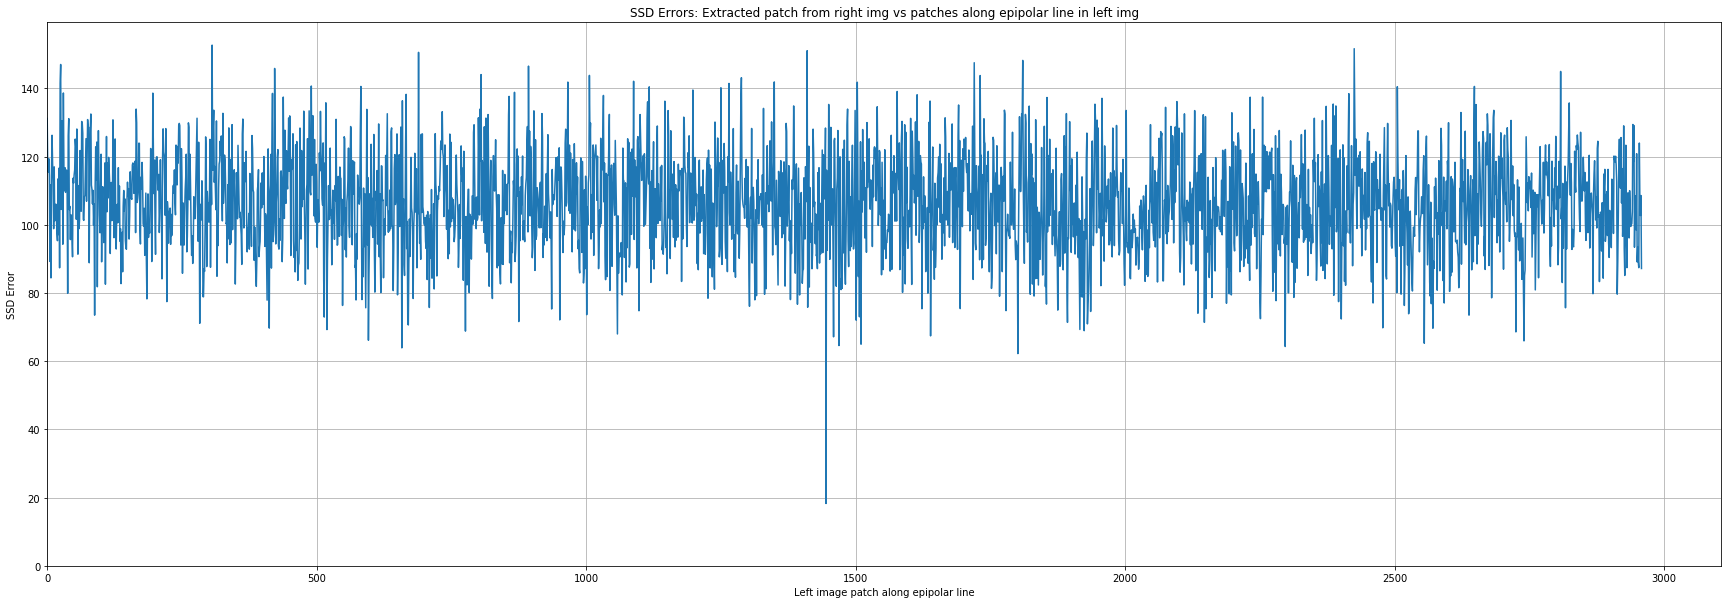

In [28]:
plt.figure(figsize=(30,10))
plt.plot(range(len(ssd)), ssd)
plt.title('SSD Errors: Extracted patch from right img vs patches along epipolar line in left img')
plt.ylabel('SSD Error')
plt.xlabel('Left image patch along epipolar line')
plt.grid(True)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.show()